## Visualizing One-Dimensional Data in Python - Density Plots

## TOC

* [1.0 New York City Airbnb Data](#1.0-New-York-City-Airbnb-Data)
* [2.0 Kernel Density: The Basics](#2.0-Kernel-Density:-The-Basics)
 * [2.1 The bandwidth parameter](#2.1-The-bandwidth-parameter)
 * [2.2 The choice of the kernel](#2.2-The-choice-of-the-kernel)
* [3.0 Kernel Density: Things to keep in mind](#3.0-Kernel-Density:-Things-to-keep-in-mind)
 * [3.1 Non-sensical Data](#3.1-Non-sensical-Data)
 * [3.2 Producing the appearance of data where none exists](#3.2-Producing-the-appearance-of-data-where-none-exists)
* [4.0 What is happening under the hood?](#4.0-What-is-happening-under-the-hood?)
 * [4.1 A homemade implementation](#4.1-A-homemade-implementation)
 * [4.2 KDEpy, Scipy, and Scikit-Learn](#4.2-KDEpy,-Scipy,-and-Scikit-Learn)

In [1]:
import os
import sys
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import math
import numpy as np
import KDEpy
import scipy
from sklearn.neighbors import KernelDensity

## 1.0 New York City Airbnb Data

As with the histograms notebook, we'll start looking at 2019 data for Airbnb accommodations.

In [2]:
listings = pd.read_csv(os.path.join(os.getcwd(), 'input', 'AB_NYC_2019.csv'))
XArr = listings['price'][listings['price']<=560]

## 2.0 Kernel Density: The Basics

A density plot is a representation of the distribution of a numeric variable. It uses a kernel density estimate to show the probability density function of the variable.

### 2.1 The bandwidth parameter

- If the bandwidth is too small, then the density estimate can become overly peaky and visually busy and the main trends in the data may be obscured. 
- If the bandwidth is too large, then smaller features in the distribution of the data may disappear

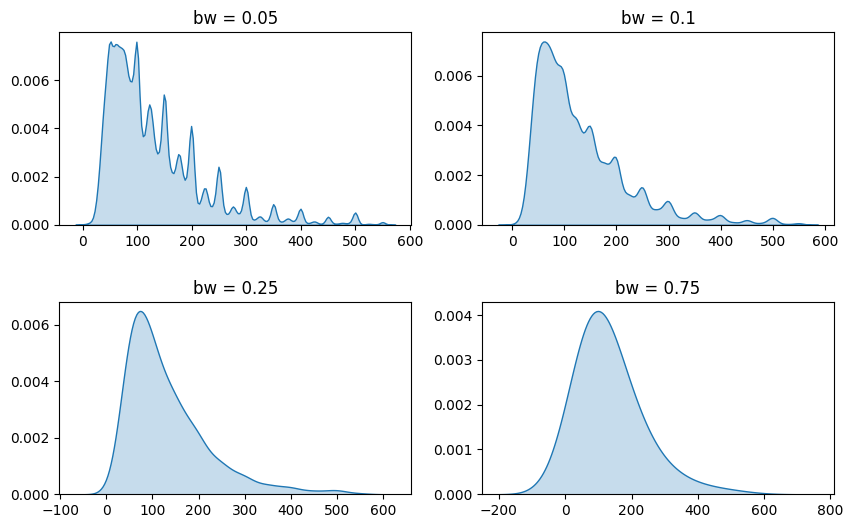

In [3]:
fig, ax = plt.subplots(2, 2, figsize = (10,6))

banwidth = [0.05, 0.1, 0.25, 0.75]
for ax_i, b, fig_num in zip(ax.flatten(), banwidth, range(1,5)):
    sns.kdeplot(data = None, x =XArr, bw_method = b, 
                fill = True, ax = ax_i) 
    ax_i.set_xlabel('')
    ax_i.set_ylabel('')
    ax_i.set_title('bw = ' + str(b))
    
plt.subplots_adjust(hspace = 0.4)

### 2.2 The choice of the kernel

- The choice of the kernel affects the shape of the density curve
- The more data points there are in the data set, the less the choice of the kernel matters. 

## 3.0 Kernel Density: Things to keep in mind

### 3.1 Non-sensical Data

One pitfall with KDE plots is that they have a tendency to produce the appearance of data where none exists, in particular in the tails. This is because of how they work under the hood (more on this later).

For this dataset, the KDE displays negative values for a variable that cannot be negative! **Prices must be positive!**

<AxesSubplot: xlabel='price', ylabel='Density'>

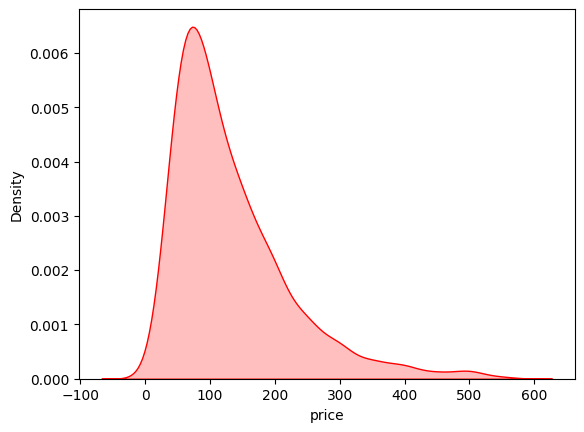

In [4]:
sns.kdeplot(data = None, x = XArr, fill = True, color = 'red', bw_method =0.25)

The `cut` and `clip` parameters can be used to control the extent of the curve, but datasets that have many observations close to a natural boundary may be better served by a different visualization method.

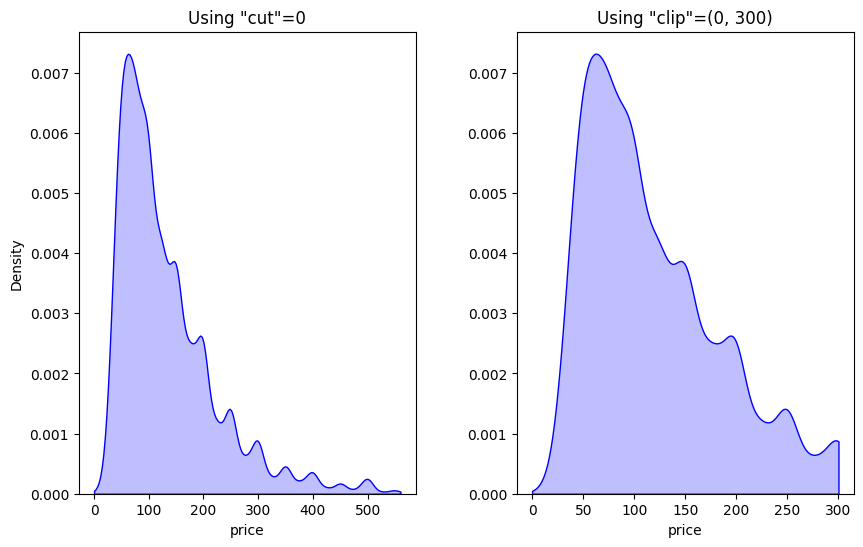

In [5]:
fig, ax = plt.subplots(1, 2, figsize = (10,6))

sns.kdeplot(data = None, x = XArr, fill = True, color = 'blue', bw_method ='scott', cut = 0, ax = ax[0])
ax[0].set_title('Using "cut"=0');

sns.kdeplot(data = None, x = XArr, fill = True, color = 'blue', bw_method ='scott', clip = (0,300), ax = ax[1])
ax[1].set_title('Using "clip"=(0, 300)');
ax[1].set_ylabel('');

plt.subplots_adjust(wspace = 0.3)

### 3.2 Producing the appearance of data where none exists

Kernel density estimates have a tendency to produce the appearance of data where none exists. 
Here we show the KDE for the entire dataset and also for a subset of it.

It is good practice to include the sample size either in the figure or in the text where the figure lives.

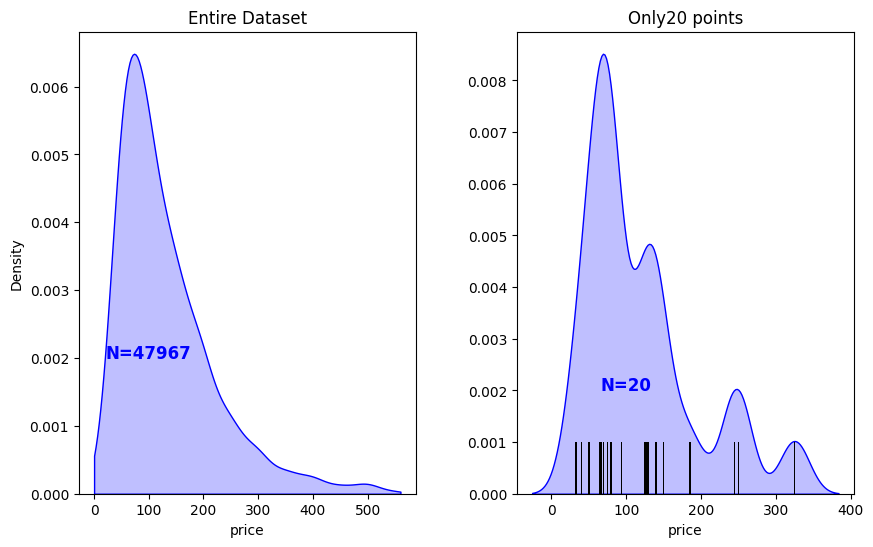

In [15]:
fig, ax = plt.subplots(1, 2, figsize = (10,6))

sns.kdeplot(data = None, x = XArr, fill = True, color = 'blue', bw_method =0.25, cut = 0, ax = ax[0])
ax[0].set_title('Entire Dataset');


subset_of_X = XArr.sample(20)
sns.kdeplot(data = None, x = subset_of_X, fill = True, color = 'blue', bw_method =0.25, ax = ax[1])

ax[1].bar(subset_of_X, height = 0.001, width = 2, color = 'black')
ax[1].set_title('Only' + str(len(subset_of_X)) +  ' points');
ax[1].set_ylabel('');


for ax_i, N in zip(ax, [len(XArr), len(subset_of_X)]):
    ax_i.text(100, 0.002, 'N=' + str(N), horizontalalignment='center', size='large', color='blue',
            weight='semibold')

plt.subplots_adjust(wspace = 0.3)
plt.show()

## 4.0 What is happening under the hood?

Trying to create your own KDE algorithm is tough! At least it was for me. Here is some clarification on the inner workings:

Kernel density estimation places a kernel (ex. gaussian, rectangular, etc) that is centered at every individual data point and all of these curves are then added together to make a single smooth density estimation.

Looking at the image below:

- Each small black vertical line on the x-axis represents a data point.
- The individual kernels (Gaussians in this example) are shown drawn in dashed red lines above each point. 
- The solid blue curve is the result of summing the individual Gaussians and that is the estimated density plot.

![](input/KDEWIKI.png)

#### Using Scipy

[docs](#https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gaussian_kde.html#scipy.stats.gaussian_kde)

In [7]:
# Kernel-density estimate using Gaussian kernels.
x1 = np.array([0.1, 0.15, 0.2, 0.5, 0.7, 0.8])
kde = scipy.stats.gaussian_kde(x1)
y1 = kde(x1)
xs = np.linspace(-0.2, 1, num=100) 
ys = kde(xs) # See Note below

The last step `y1 = kde(xs)` could have been confusing. 

The idea is that we first initialize gaussian kernel density estimator with the original data and we then evaluate the estimated pdf on a set of points "support" (which typically has more points than the original dataset).

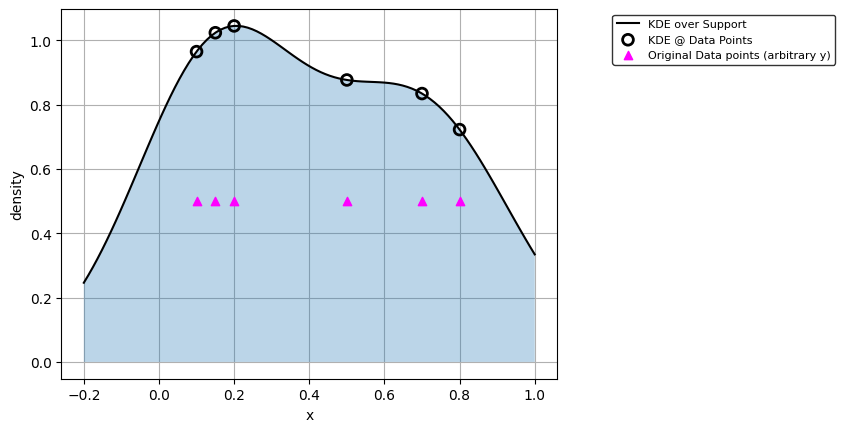

In [8]:
# Plotting
fig, ax = plt.subplots()
ax.fill_between(xs, ys, alpha = 0.3)
ax.plot(xs, ys, color = 'black', label="KDE over Support")
ax.scatter(x1, y1, marker = 'o', s = 60, facecolor='none', edgecolor ='black', label='KDE @ Data Points', linewidth = 2)
ax.scatter(x1, np.full(x1.shape, 0.5), marker = '^', color = 'magenta', label='Original Data points (arbitrary y)')
ax.grid()
ax.set_axisbelow(True)
ax.legend()
ax.set_ylabel('density')
ax.set_xlabel('x');
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, bbox_to_anchor=(1.10, 1), 
            loc="upper left", fontsize = 8, edgecolor = 'black')
plt.show()

#### Looking at the `Seaborn` source code:

<div>
<img src="input/seaborn_snippets.png" width="900"/>
</div>

### 4.1 A homemade implementation

In [9]:
def gaussian_kernel(u):
    return (1/np.sqrt(2*np.pi))*np.exp(-0.5*u**2)

def apply_KDE(arr, kernel, h):

    """
    Args:
        arr (np.ndarray): Data points.
        kernel (func): Usually, but not always, K will be a symmetric
            probability density function, the normal density, for instance.
        h (float): Window width, also called the smoothing parameter or 
            bandwidth by some authors.
    """

    # The KDE first smooths each data point into a density bump and then (2)
    # sums them up to obtain the final density estimate.
    # We'll do this by cumulative summing at each data point in the array.
    pdf = np.zeros(shape = arr.shape)
    N = len(arr)

    # Center Kernel at each point 
    for i, center in enumerate(arr):

        # Calculate the normalized distance from center and 
        # add to the cumulative sum.
        u = abs(center-arr) / h
        K_u = (1/(N*h)) * kernel(u)        
        pdf += K_u

    return pdf


# Get bandwith used in Scipy
bw = KDEpy.bw_selection.scotts_rule(x1.reshape(-1,1))
y_in_house = apply_KDE(x1, gaussian_kernel, bw)

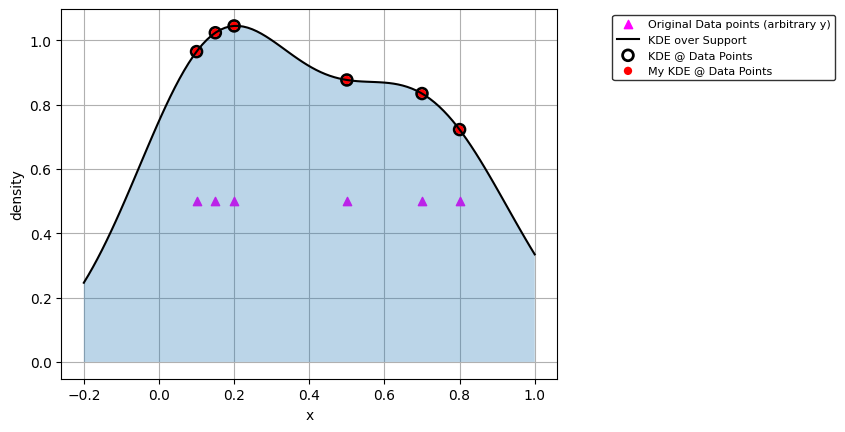

In [10]:
# Plotting
fig, ax = plt.subplots()

# Original Data
ax.scatter(x1, np.full(x1.shape, 0.5), marker = '^', color = 'magenta', label='Original Data points (arbitrary y)')

# Scipy Results
ax.fill_between(xs, ys, alpha = 0.3)
ax.plot(xs, ys, color = 'black', label="KDE over Support")
ax.scatter(x1, y1, marker = 'o', s = 60, facecolor='none', edgecolor ='black', label='KDE @ Data Points', linewidth = 2)

# My Results
ax.scatter(x1, y_in_house, label='My KDE @ Data Points', marker = 'o', facecolor='red', edgecolor ='none')

# Graph Aesthetics
ax.grid()
ax.set_axisbelow(True)
ax.legend()
ax.set_ylabel('density')
ax.set_xlabel('x');
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, bbox_to_anchor=(1.10, 1), loc="upper left", fontsize = 8, edgecolor = 'black')
plt.show()

### 4.2 KDEpy, Scipy, and Scikit-Learn

There are different implementations of the KDE algorithm in Python.

**The arguments in the functions do not represent the same thing!**

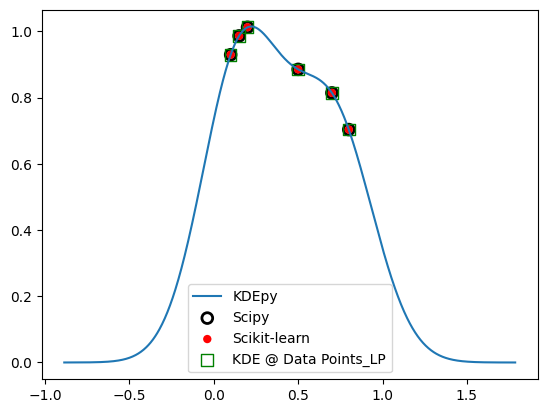

In [11]:
fig, ax = plt.subplots()

X = np.array([0.1, 0.15, 0.2, 0.5, 0.7, 0.8])

# KDEpy
x, y = KDEpy.NaiveKDE(kernel="gaussian", bw="silverman").fit(X).evaluate()
ax.plot(x, y, label = 'KDEpy')

# Scipy 
kernel = scipy.stats.gaussian_kde(X, bw_method="silverman")
y = kernel.evaluate(X)
ax.scatter(X, y, marker = 'o', s = 60, facecolor='none', edgecolor ='black', linewidth = 2, label = 'Scipy')

# Scikit_learn
bw = KDEpy.bw_selection.silvermans_rule(X.reshape(-1,1)) # We need to get the bandwith
kde = KernelDensity(kernel='gaussian', bandwidth=bw).fit(X.reshape(-1,1))
y = np.exp(kde.score_samples(X.reshape(-1,1)))
ax.scatter(X, y,marker = 'o', facecolor='red', edgecolor ='none',  label = 'Scikit-learn')

# My Results
y_in_house = apply_KDE(X, gaussian_kernel, bw)
ax.scatter(x1, y_in_house, label='KDE @ Data Points_LP', s = 70, marker = 's', facecolor='none', edgecolor ='green')

plt.legend()